In [1]:
import os
import re

from sklearn.metrics import cohen_kappa_score
import itertools

from typing import Dict, List

import numpy as np
import pandas as pd

from tqdm import tqdm
from enum import Enum

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'cm'

import seaborn as sns
sns.set()
sns.set(font_scale=3)  # crazy big
sns.set_style("whitegrid")

In [2]:
DATA_PATH = os.path.join('..', 'data', 'annotated_data')

In [3]:
def read_data():
    doc_annotations = {}
    text_lengths = {}

    authors_set = set()

    for author_folder in os.listdir(DATA_PATH):
        authors_set.add(author_folder)
        full_path = os.path.join(DATA_PATH, author_folder)
        ann_files = list(filter(lambda x: x.endswith('.ann'), os.listdir(full_path)))
        for filename in ann_files:
            doc_name = os.path.splitext(filename)[0]
            if doc_name not in doc_annotations.keys():
                doc_annotations[doc_name] = {}

            if author_folder in doc_annotations[doc_name].keys():
                raise Exception(f'Author "{author_folder}" has duplicated annotation for document "{doc_name}"')

            with open(os.path.join(full_path, filename), 'r') as file_handler:
                doc_annotations[doc_name][author_folder] = file_handler.read()

            if doc_name not in text_lengths.keys():
                with open(os.path.join(full_path, f'{doc_name}.txt'), 'r') as txt_file_handler:
                    text_lengths[doc_name] = len(txt_file_handler.read())

    return doc_annotations, text_lengths, list(sorted(authors_set))

In [4]:
doc_annotations, text_lengths, authors_set = read_data()

In [5]:
valid_annotations = {
    k: v for k, v in doc_annotations.items()
    if len(v.keys()) > 1
}

In [6]:
class Annotation:
    def __init__(self, key: str, entity: str, start_pos: int, end_pos: int):
        self.key = key
        self.entity = entity
        self.start_pos = start_pos
        self.end_pos = end_pos

    def __str__(self):
        return f'<{self.key}-{self.entity}-[{self.start_pos}:{self.end_pos}]>'

In [7]:
class AnnotationType(Enum):
    Unknown = 0
    Base = 1
    PersonGender = 2
    PersonLegalStatus = 3
    PersonRole = 4
    OrganizationNotary = 5
    OrganizationBeneficiary = 5

In [8]:
def get_annotation_type(annotation_str: str) -> AnnotationType:
    annotation_parts = annotation_str.split('\t')
    if re.search('([T]{1}[0-9]+)', annotation_parts[0]):
        return AnnotationType.Base

    if not re.search('([A]{1}[0-9]+)', annotation_parts[0]):
        # print(annotation_str)
        return AnnotationType.Unknown

    if annotation_parts[1].startswith('Gender'):
        return AnnotationType.PersonGender

    if annotation_parts[1].startswith('LegalStatus'):
        return AnnotationType.PersonLegalStatus

    if annotation_parts[1].startswith('Role'):
        return AnnotationType.PersonRole

    if annotation_parts[1].startswith('Notary'):
        return AnnotationType.OrganizationNotary

    if annotation_parts[1].startswith('Beneficiary'):
        return AnnotationType.OrganizationBeneficiary

    raise Exception(f'Unknown sub-entity annotation: {annotation_str}')

In [9]:
def get_base_entity_positions(annotation_parts: List[str]):
    split_annotation = annotation_parts[0].split(' ')
    current_annotations_parts = ' '.join(split_annotation[1:]).split(';')
    start = int(current_annotations_parts[0].split(' ')[0])
    end = int(current_annotations_parts[-1].split(' ')[-1])
    return (start, end)

In [10]:
invalid_labels = ['DuplicatePage', 'TranscriptionError_Document']

class DocumentAnnotation:
    def __init__(self, doc_key: str, annotations_str: str, text_length: int, labels_to_use: List[str], annotation_type: AnnotationType):
        self.doc_key = doc_key
        self.text_length = text_length
        self.is_valid=True

        self.annotations = self._parse_annotations(annotations_str, labels_to_use, annotation_type)

    def is_empty(self) -> bool:
        return len(self.annotations) == 0

    def _parse_annotations(self, annotations_str: str, labels_to_use: List[str], annotation_type: AnnotationType):
        result = []
        annotations = annotations_str.split('\n')

        entity_positions = {}

        for annotation in annotations:
            annotation_parts = annotation.split('\t')

            current_annotation_type = get_annotation_type(annotation)
            if current_annotation_type == AnnotationType.Unknown:
                continue

            entity_id = annotation_parts[0]
            if current_annotation_type == AnnotationType.Base:
                main_entity_id = annotation_parts[0]
                entity_positions[main_entity_id] = get_base_entity_positions(annotation_parts[1:])

            if current_annotation_type != annotation_type:
                continue

            if len(annotation_parts) < 2: print(annotation_parts)

            split_annotation = annotation_parts[1].split(' ')
            label = split_annotation[0]

            if current_annotation_type != AnnotationType.Base:
                main_entity_id = split_annotation[1]

            if label in invalid_labels:
                continue

            if labels_to_use is not None and label not in labels_to_use:
                continue

            result.append(
                Annotation(
                    key=entity_id,
                    entity=label,
                    start_pos=entity_positions[main_entity_id][0],
                    end_pos=entity_positions[main_entity_id][1]))

        return result

In [11]:
def parse_annotations(valid_annotations, text_lengths: Dict[str, int], labels_to_use: List[str], annotation_type: AnnotationType):
    parsed_annotations = {
        doc_key: {
            author: DocumentAnnotation(doc_key, annotations, text_lengths[doc_key], labels_to_use, annotation_type)
            for author, annotations in annotations_per_author.items()
        }
        for doc_key, annotations_per_author in valid_annotations.items()
    }

    # Remove invalid annotations
    parsed_annotations = {
        doc_key: {
            author: doc_annotation
            for author, doc_annotation in annotations_per_author.items()
            if doc_annotation.is_valid and not doc_annotation.is_empty()
        }
        for doc_key, annotations_per_author in parsed_annotations.items()
    }

    # Remove documents where we are left with only one annotation
    parsed_annotations = {
        doc_key: annotations_per_author
        for doc_key, annotations_per_author in parsed_annotations.items()
        if len(annotations_per_author.keys()) > 1
    }

    return parsed_annotations

In [12]:
def annotations_overlap(annotation1: Annotation, annotation2: Annotation, offset_chars: int, match_entity: bool) -> bool:
    # if the two annotations do not even overlap with one character, we return false
    if (annotation1.start_pos > annotation2.end_pos or
        annotation1.end_pos < annotation2.start_pos):
        return False

    if match_entity and (annotation1.entity != annotation2.entity):
        return False

    out_of_boundary_chars = abs(annotation1.start_pos - annotation2.start_pos) + abs(annotation1.end_pos - annotation2.end_pos)

    result = out_of_boundary_chars <= offset_chars
    return result

In [13]:
def print_mapped_annotations(mapped_annotations: dict):
    for ann1, ann2 in mapped_annotations.items():
        print(f'{ann1.key} <{ann1.start_pos}-{ann1.end_pos}>  ---', end='')
        if ann2 is None:
            print('NONE')
        else:
            print(f'{ann2.key} <{ann2.start_pos}-{ann2.end_pos}>')

In [14]:
def get_overlapping_annotation(annotation_to_compare: Annotation, annotations: List[Annotation], keys_to_skip: List[str], offset_chars: int, match_entity: bool) -> Annotation:
    overlaps = []
    for annotation2 in annotations:

        if annotation_to_compare.start_pos > annotation2.end_pos:
            continue

        if annotation2.key in keys_to_skip:
            continue

        if annotations_overlap(annotation_to_compare, annotation2, offset_chars, match_entity):
            overlaps.append(annotation2)

    if len(overlaps) == 0:
        return None

    for overlap in overlaps:
        if overlap.entity == annotation_to_compare.entity:
            return overlap

    return overlaps[0]

In [15]:
def calculate_entity_overlap(doc_annotation1: DocumentAnnotation, doc_annotation2: DocumentAnnotation, offset_chars: int, debug: bool = False):
    assert (doc_annotation1.doc_key == doc_annotation2.doc_key)

    mapped_annotations = {}
    used_counter_annotations = set()
    empty_positions = [1 for _ in range(0, doc_annotation1.text_length)]
    for annotation in doc_annotation1.annotations:
        for i in range(annotation.start_pos, annotation.end_pos):
            empty_positions[i] = 0

    # Perform iteration using strict overlap matching
    for annotation in doc_annotation1.annotations:
        overlapping_annotation = get_overlapping_annotation(annotation, doc_annotation2.annotations, used_counter_annotations, offset_chars, match_entity=True)
        if overlapping_annotation is not None:
            used_counter_annotations.add(overlapping_annotation.key)
            mapped_annotations[annotation] = overlapping_annotation

    # Perform iteration using loose overlap matching
    for annotation in doc_annotation1.annotations:
        if annotation in mapped_annotations.keys():
            continue

        overlapping_annotation = get_overlapping_annotation(annotation, doc_annotation2.annotations, used_counter_annotations, offset_chars, match_entity=False)
        if overlapping_annotation is not None:
            used_counter_annotations.add(overlapping_annotation.key)

        mapped_annotations[annotation] = overlapping_annotation

    if debug:
        print_mapped_annotations(mapped_annotations)
    annotation_maps = [ x.entity for x in mapped_annotations.keys() ]
    counter_annotations = [ x.entity if x is not None else 'O' for x in mapped_annotations.values() ]

    for annotation2 in doc_annotation2.annotations:
        for i in range(annotation2.start_pos, annotation2.end_pos):
            empty_positions[i] = 0

        if annotation2.key in used_counter_annotations:
            continue

        annotation_maps.append('O')
        counter_annotations.append(annotation2.entity)

    free_positions = sum(empty_positions)
    for _ in range(free_positions):
        annotation_maps.append('O')
        counter_annotations.append('O')

    if annotation_maps == counter_annotations:
        result = 1
    else:
        result = cohen_kappa_score(annotation_maps, counter_annotations)

    return result

In [16]:
def create_comparison_matrix(parsed_annotations, offset_chars: int, authors_set: set, authors:List[str]=None):
    comparisons = {
        author_1 : {
            author_2: []
            for author_2 in authors_set
        } for author_1 in authors_set
    }

    for _, annotations in parsed_annotations.items():
        for author_1, author_2 in itertools.product(authors_set, authors_set):
            if author_1 in annotations.keys() and author_2 in annotations.keys():
                kappa_score = calculate_entity_overlap(annotations[author_1], annotations[author_2], offset_chars)
                comparisons[author_1][author_2].append(kappa_score)

        for author in authors_set:
            comparisons[author][author] = [1]

    return comparisons

In [17]:
def print_comparison_matrix(comparisons, authors_set: List[str], offset_chars: int, labels_to_use: List[str]):
    print('Result')
    print(f'- offset characters: {offset_chars}')
    print(f'- used labels: {", ".join(labels_to_use)}')
    print('----------------------------------------------')
    print('\t', end='')
    print('\t'.join(authors_set))
    for author_1 in authors_set:
        print(author_1, end='\t')
        for author_2 in authors_set:
            print(round(np.mean(comparisons[author_1][author_2]), 2), end='\t')

        print()

In [18]:
def plot_comparison_lines(values_per_offset, authors_set, ax=None):
    sns.set_palette(sns.color_palette('husl', 15))
    offset_chars = list(values_per_offset.keys())
    passed_authors = []
    for author1 in authors_set:
        for author2 in authors_set:
            if author1 == author2: continue

            if (author1, author2) in passed_authors or (author2, author1) in passed_authors:
                continue

            y = [np.mean(x[author1][author2]) for x in values_per_offset.values() if author1 in x.keys() and author2 in x[author1].keys()]
            if all(x is None for x in y):
                continue

            label = f'{author1}, {author2}'
            ax = sns.lineplot(x=offset_chars, y=y, label=label,ax=ax)
            passed_authors.append((author1, author2))

    plt.legend(title='Author pairs')
    ax.set_xlabel("Fuzzy matching offset")
    ax.set_ylabel("Kappa score")
    ax.set_title("(a)", pad=20)
    ax.set(xlim=(0, 50), ylim=(0, 1))
    return ax
    # plt.show()

In [19]:
def create_axes():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    return ax

In [20]:
def plot_confidence_intervals(values_per_offset, authors_set, color: str, ax=None, label=None, show: bool = True):
    if ax is None:
        ax = create_axes()

    sns.set_palette('tab10')
    offset_chars = list(values_per_offset.keys())
    y_values = [[] for _ in offset_chars]
    passed_authors = []
    for author1 in authors_set:
        for author2 in authors_set:
            if author1 == author2: continue

            if (author1, author2) in passed_authors or (author2, author1) in passed_authors:
                continue

            pair_label = f'{author1}, {author2}'
            y = [[pair_label, offset, np.mean(x[author1][author2])] for offset, x in values_per_offset.items() if author1 in x.keys() and author2 in x[author1].keys() and len(x[author1][author2]) > 0]
            if any(x is None for x in y): 
                continue

            y_values.extend(y)

    df = pd.DataFrame(y_values,columns=['pairs', 'Fuzzy matching offset', 'Kappa score'])
    ax = sns.lineplot(data=df, x='Fuzzy matching offset', y='Kappa score', ax=ax, label=label, palette=[color])
    ax.set(xlim=(0, 50), ylim=(0, 1))
    ax.set_title("(b)", pad=20)
    plt.legend(title='Entity types')

    # if show:
    #     plt.show()

    return ax

In [21]:
def calculate_comparisons(valid_annotations, text_lengths: Dict[str, int], authors_set: List[str], offset_chars: List[int], labels_to_use: List[str], annotation_type: AnnotationType = AnnotationType.Base):
    parsed_annotations = parse_annotations(valid_annotations, text_lengths, labels_to_use, annotation_type)

    values_per_offset = {
        offset_char: create_comparison_matrix(parsed_annotations, offset_char, authors_set)
        for offset_char in tqdm(offset_chars)
    }

    return values_per_offset

In [22]:
offset_chars = list(range(0, 51))

labels_to_use=['Person', 'Place', 'Organization']

In [23]:
import _pickle as pickle

def load_or_init(pickle_name, init_action):
    try:
        extension = '.pickle'
        filepath = f'{pickle_name}{extension}'
        with (open(filepath, "rb")) as openfile:
            obj = pickle.load(openfile)

    except FileNotFoundError:
        obj = init_action()
        with open(filepath, 'wb') as handle:
            pickle.dump(obj, handle, protocol=-1)

    return obj

In [24]:
values_per_offset = load_or_init('all_values', lambda: calculate_comparisons(valid_annotations, text_lengths, authors_set, offset_chars=offset_chars, labels_to_use=labels_to_use))

In [25]:
def filter_values(values_per_offset, specific_author: str):
    specific_values_per_offset = {
        offset: {
            author_1: {
                author_2: values
                for author_2, values in values_per_author.items()
                if author_1 == specific_author or author_2 == specific_author
            }
            for author_1, values_per_author in values_per_authors.items()
        }
        for offset, values_per_authors in values_per_offset.items()
    }

    return specific_values_per_offset

<AxesSubplot:title={'center':'(a)'}, xlabel='Fuzzy matching offset', ylabel='Kappa score'>

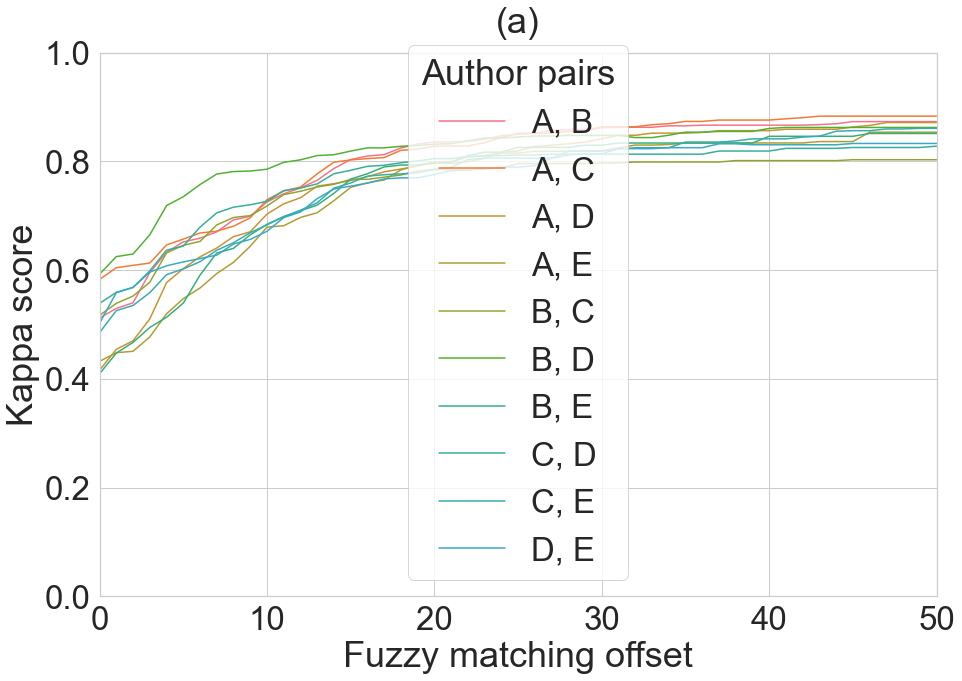

In [26]:
plot_comparison_lines(values_per_offset, authors_set)

In [27]:
# bert_values_per_offset = filter_values(values_per_offset, specific_author='Bert')

In [28]:
# plot_comparison_lines(bert_values_per_offset, authors_set)

<AxesSubplot:title={'center':'(b)'}, xlabel='Fuzzy matching offset', ylabel='Kappa score'>

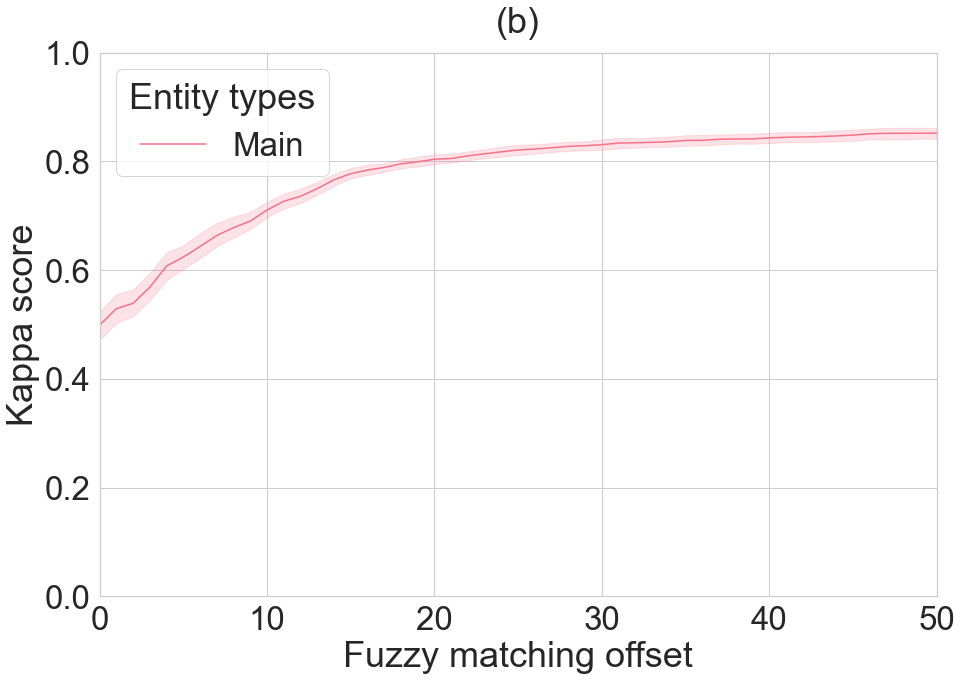

In [29]:
plot_confidence_intervals(values_per_offset, authors_set, color='blue', label='Main')

In [30]:
# plot_confidence_intervals(bert_values_per_offset, authors_set)

In [31]:
gender_values_per_offset = load_or_init('gender_values', lambda: calculate_comparisons(valid_annotations, text_lengths, authors_set, offset_chars=offset_chars, labels_to_use=None, annotation_type=AnnotationType.PersonGender))
legal_status_values_per_offset = load_or_init('ls_values', lambda: calculate_comparisons(valid_annotations, text_lengths, authors_set, offset_chars=offset_chars, labels_to_use=None, annotation_type=AnnotationType.PersonLegalStatus))
role_values_per_offset = load_or_init('role_values', lambda: calculate_comparisons(valid_annotations, text_lengths, authors_set, offset_chars=offset_chars, labels_to_use=None, annotation_type=AnnotationType.PersonRole))

In [32]:
notary_values_per_offset = load_or_init('notary_values', lambda: calculate_comparisons(valid_annotations, text_lengths, authors_set, offset_chars=offset_chars, labels_to_use=None, annotation_type=AnnotationType.OrganizationNotary))
beneficiary_values_per_offset = load_or_init('benef_values', lambda: calculate_comparisons(valid_annotations, text_lengths, authors_set, offset_chars=offset_chars, labels_to_use=None, annotation_type=AnnotationType.OrganizationBeneficiary))

No handles with labels found to put in legend.


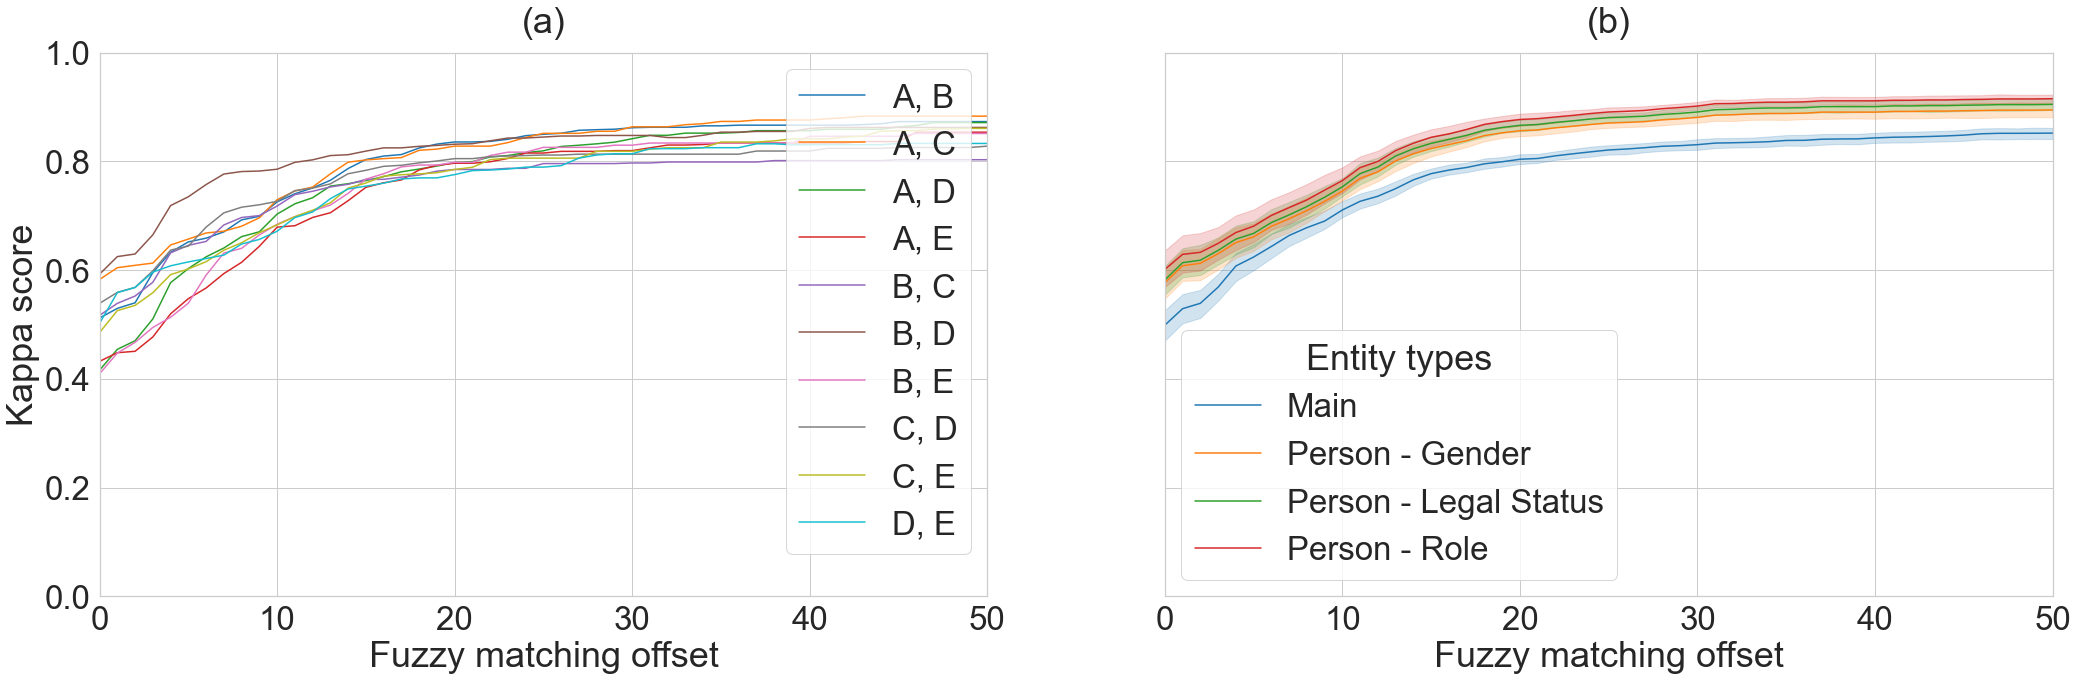

In [33]:
f,(ax1,ax2) = plt.subplots(1,2, sharey=True)
# ax1.get_shared_y_axes().join(ax2)
f.set_figwidth(35)

ax1 = plot_comparison_lines(values_per_offset, authors_set, ax=ax1)
ax2 = plot_confidence_intervals(values_per_offset, authors_set, ax=ax2, color='blue', label='Main', show=False)
ax2 = plot_confidence_intervals(gender_values_per_offset, authors_set, ax=ax2, color='red', label='Person - Gender', show=False)
ax2 = plot_confidence_intervals(legal_status_values_per_offset, authors_set, ax=ax2, color='green', label='Person - Legal Status', show=False)
ax2 = plot_confidence_intervals(role_values_per_offset, authors_set, ax=ax2, color='yellow', label='Person - Role')

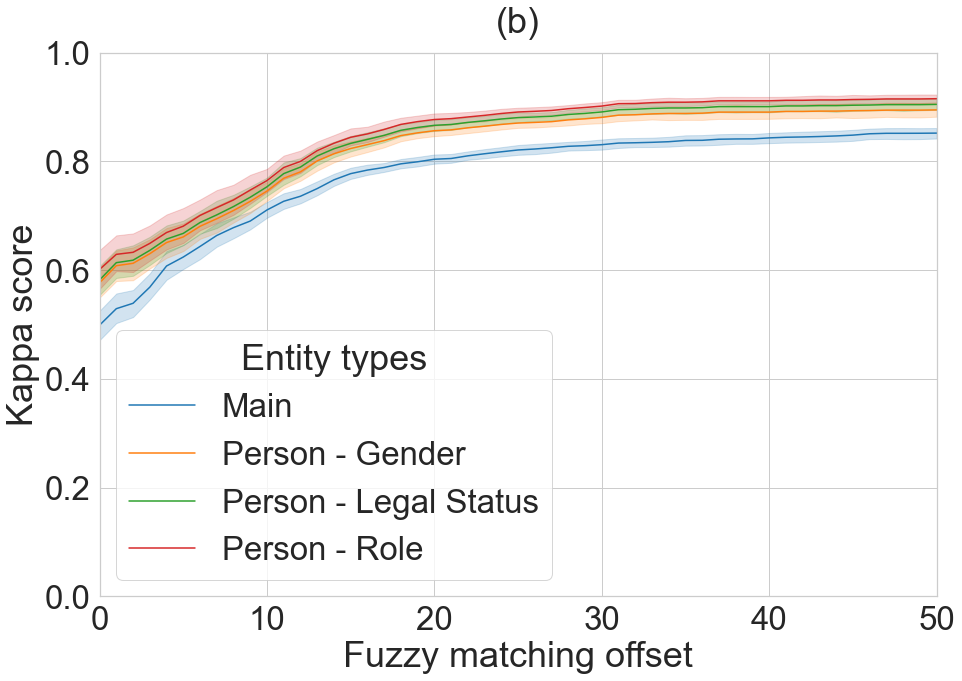

In [34]:
ax = create_axes()
ax = plot_confidence_intervals(values_per_offset, authors_set, ax=ax, color='blue', label='Main', show=False)
ax = plot_confidence_intervals(gender_values_per_offset, authors_set, ax=ax, color='red', label='Person - Gender', show=False)
ax = plot_confidence_intervals(legal_status_values_per_offset, authors_set, ax=ax, color='green', label='Person - Legal Status', show=False)
ax = plot_confidence_intervals(role_values_per_offset, authors_set, ax=ax, color='yellow', label='Person - Role')

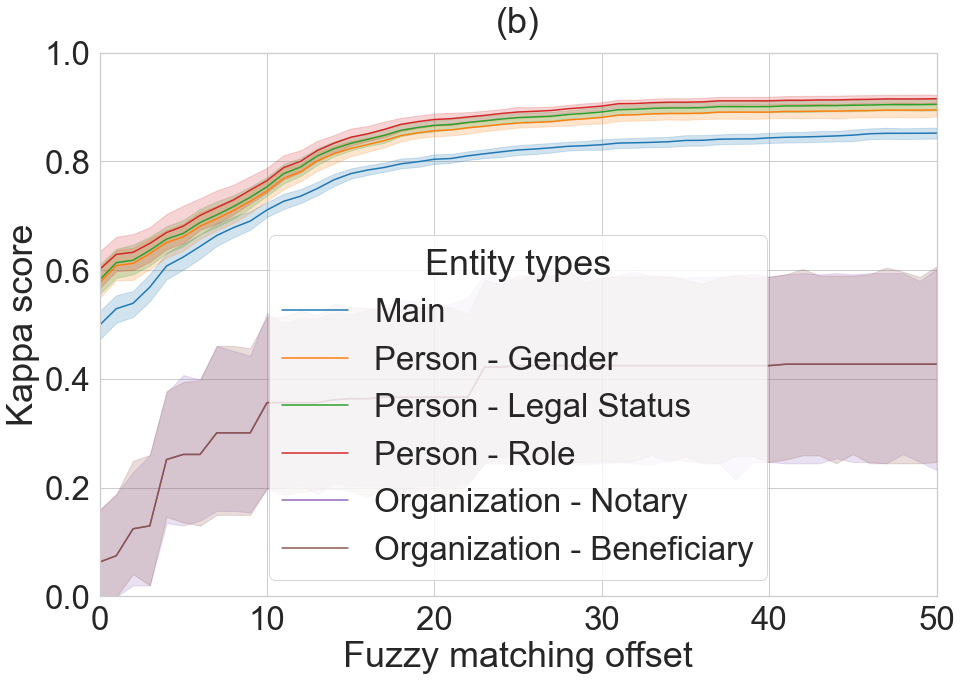

In [35]:
ax = create_axes()

ax = plot_confidence_intervals(values_per_offset, authors_set, ax=ax, color='blue', label='Main', show=False)
ax = plot_confidence_intervals(gender_values_per_offset, authors_set, ax=ax, color='red', label='Person - Gender', show=False)
ax = plot_confidence_intervals(legal_status_values_per_offset, authors_set, ax=ax, color='green', label='Person - Legal Status', show=False)
ax = plot_confidence_intervals(role_values_per_offset, authors_set, ax=ax, color='yellow', label='Person - Role', show=False)
ax = plot_confidence_intervals(notary_values_per_offset, authors_set, ax=ax, color='pink', label='Organization - Notary', show=False)
ax = plot_confidence_intervals(beneficiary_values_per_offset, authors_set, ax=ax, color='cyan', label='Organization - Beneficiary')